# Initialization

## Imports


In [25]:
# add src to path
from pyprojroot import here
import sys

sys.path.append(str(here("src")))

# set use of cpu cores
from code.models import *
from code.analysis_utils import *

# load other libraries
from dotenv import load_dotenv
import logging
from pandas.errors import SettingWithCopyWarning

load_dotenv()

from code.make_figs import FigureGenerator
from code.analysis_pipeline import AnalysisPipeline

# suppress logging and warnings
import warnings

logging.getLogger("code.utils").setLevel(
    logging.WARNING
)  # suppress logging of dataset sizes from train_utils
logging.getLogger("code.models").setLevel(
    logging.WARNING
)  # suppress logging of model parameters from models.py
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# configure numpy and pytorch to print entire arrays/tensors
np.set_printoptions(threshold=np.inf)
torch.set_printoptions(threshold=torch.inf)

## Set up analysis pipeline


In [26]:
# choose variables to evaluate
CONTEXT_LENGTH_TO_EVAL = [128, 256, 320]
MLP_EXPANSION_FACTOR_TO_EVAL = [4]
NUM_DIMS_TO_EVAL = [12]
NUM_TASKS_TO_EVAL = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
SAVE_FIGS = False
SETTING = "categorical-sequence"
EXP_NAME = "full-exp-params"

fixed_values = {
    "context_length": CONTEXT_LENGTH_TO_EVAL[0],
    "mlp_expansion_factor": MLP_EXPANSION_FACTOR_TO_EVAL[0],
    "num_dims": NUM_DIMS_TO_EVAL[0],
}

analysis_pipeline = AnalysisPipeline(
    setting=SETTING,
    exp_name=EXP_NAME,
    context_length_to_eval=CONTEXT_LENGTH_TO_EVAL,
    mlp_expansion_factor_to_eval=MLP_EXPANSION_FACTOR_TO_EVAL,
    num_dims_to_eval=NUM_DIMS_TO_EVAL,
)

experiment params:  {'setting': 'categorical-sequence', 'num_dims_lst': [8, 12, 16], 'num_tasks_lst': [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], 'context_length_lst': [128, 256, 320], 'mlp_expansion_factor_lst': [0.5, 4, 8], 'random_seed': 1, 'num_hidden_layers': 1, 'hidden_size': 64, 'batch_size': 64, 'learning_rate': 0.0005, 'max_steps': 100000, 'save_steps': [20, 58, 115, 193, 291, 408, 545, 703, 879, 1076, 1293, 1529, 1785, 2062, 2357, 2673, 3009, 3364, 3739, 4135, 4549, 4984, 5439, 5913, 6407, 6921, 7455, 8009, 8583, 9176, 9789, 10422, 11075, 11748, 12441, 13153, 13885, 14637, 15409, 16201, 17013, 17844, 18695, 19566, 20457, 21368, 22298, 23249, 24219, 25209, 26219, 27249, 28298, 29368, 30457, 31566, 32695, 33844, 35012, 36201, 37409, 38637, 39885, 41153, 42440, 43747, 45075, 46422, 47789, 49175, 50582, 52008, 53455, 54921, 56407, 57912, 59438, 60983, 62548, 64133, 65738, 67363, 69008, 70672, 72356, 74060, 75784, 77528, 79291, 81075, 82878, 84701, 86544, 88407, 90289, 92

  0%|          | 0/29700 [00:00<?, ?it/s]

## Process data

In [13]:
algo_df = analysis_pipeline.process_algo_df(
    analysis_pipeline.algo_df_raw,
    num_dims_to_eval=NUM_DIMS_TO_EVAL,
    context_length_to_eval=CONTEXT_LENGTH_TO_EVAL,
    num_tasks_to_eval=NUM_TASKS_TO_EVAL,
    load_saved_evaluation=True,
)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

In [14]:
transformer_df_all_checkpoints = analysis_pipeline.process_transformer_df(
    analysis_pipeline.transformer_df_raw,
    algo_df=algo_df,
    num_dims_to_eval=NUM_DIMS_TO_EVAL,
    context_length_to_eval=CONTEXT_LENGTH_TO_EVAL,
    num_tasks_to_eval=NUM_TASKS_TO_EVAL,
    mlp_expansion_factor_to_eval=MLP_EXPANSION_FACTOR_TO_EVAL,
    load_saved_evaluation=True,
    compute_distance_from_algos=True,
)

transformer_df = find_approximate_interpolation_threshold(
    transformer_df_all_checkpoints,
    threshold_percentile=0.1 if SETTING == "linear-regression" else 0.2,
).query("included_in_interpolation_analysis == 1", engine="python")

  0%|          | 0/3300 [00:00<?, ?it/s]

  0%|          | 0/3300 [00:00<?, ?it/s]

In [15]:
for context_length in CONTEXT_LENGTH_TO_EVAL:
    model_fitter = HierarchicalBayesianModelFitter(
        transformer_df=transformer_df,
        algo_df=algo_df,
        mlp_expansion_factor=MLP_EXPANSION_FACTOR_TO_EVAL[-1],
        context_length=context_length,
        num_dims=NUM_DIMS_TO_EVAL[-1],
        params_init=analysis_pipeline.params_init,
        metric_name=analysis_pipeline.metric_name,
        load_saved_evaluation=True,
        remove_last_prediction=analysis_pipeline.remove_last_prediction,
        context_dependent_weights=True,
        fit_with_ood=True,
        add_to_df=True,
        baseline_lst=["optimal_constant_baseline"],
        out_column="bms_results_context_dependent",
    )
    transformer_df, history, model = model_fitter.fit()

batch_size:  64
train_checkpoints: [  193   291   408   545   703   879  1076  1293  1529  1785  2062  2357
  2673  3009  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455
  8009  8583  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409
 16201 17013 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219
 27249 28298 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885
 41153 42440 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407
 57912 59438 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1067 [00:00<?, ?it/s]

batch_size:  64
train_checkpoints: [  193   291   408   545   703   879  1076  1293  1529  1785  2062  2357
  2673  3009  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455
  8009  8583  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409
 16201 17013 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219
 27249 28298 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885
 41153 42440 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407
 57912 59438 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1067 [00:00<?, ?it/s]

batch_size:  64
train_checkpoints: [  193   291   408   545   703   879  1076  1293  1529  1785  2062  2357
  2673  3009  3364  3739  4135  4549  4984  5439  5913  6407  6921  7455
  8009  8583  9176  9789 10422 11075 11748 12441 13153 13885 14637 15409
 16201 17013 17844 18695 19566 20457 21368 22298 23249 24219 25209 26219
 27249 28298 29368 30457 31566 32695 33844 35012 36201 37409 38637 39885
 41153 42440 43747 45075 46422 47789 49175 50582 52008 53455 54921 56407
 57912 59438 60983 62548 64133 65738] 
train_num_tasks: [   4    8   16   32   64  128  256  512 1024]


Loading saved BMS results for all rows:   0%|          | 0/1067 [00:00<?, ?it/s]

# Analysis


In [16]:
# set up FigureGenerator
fig_gen = FigureGenerator(
    transformer_df, transformer_df_all_checkpoints, algo_df, SETTING
)

Registered Avenir font from: /sailhome/wurgaft/.fonts/Avenir.ttc


## Relative distance phase diagram

Bbox(x0=0.12355555555555559, y0=0.15546296296296302, x1=0.8588659793814433, y1=0.975)


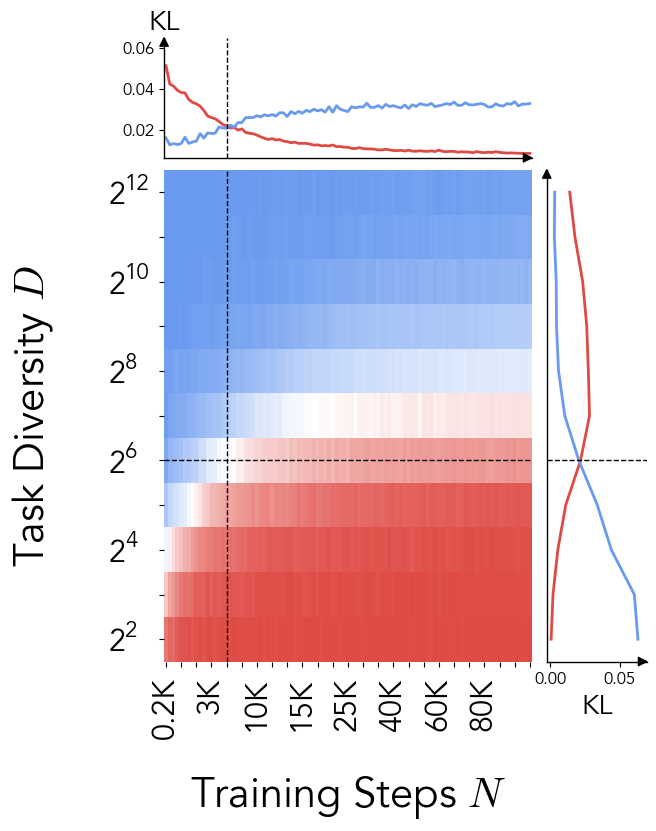

Bbox(x0=0.12355555555555559, y0=0.15546296296296302, x1=0.8588659793814433, y1=0.975)


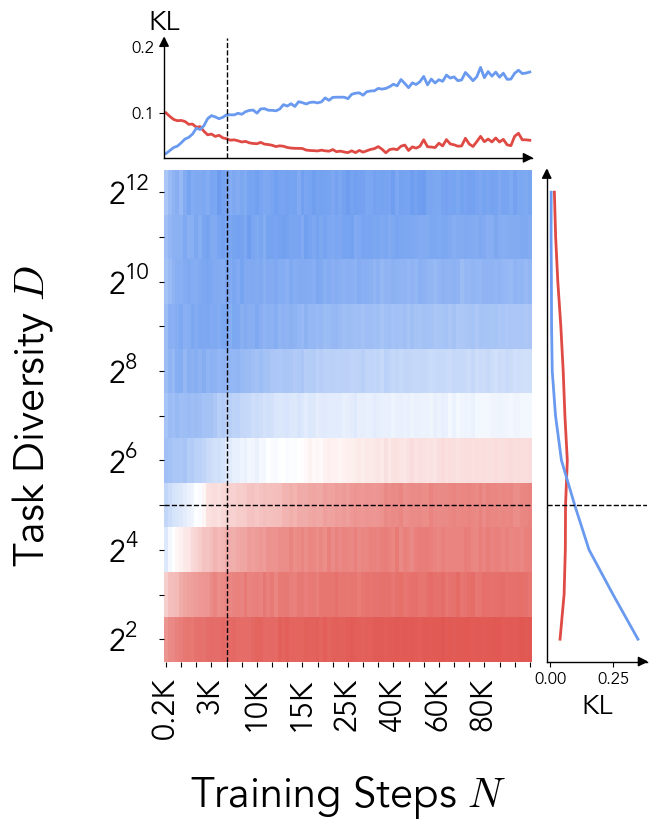

In [17]:
fig_gen.generate_relative_distance_plot(
    config={
        "fixed_values": fixed_values,
        "x_annotated": 16,
        "y_annotated": 4,
        "mode": "train",
    },
    show=True,
    save=SAVE_FIGS,
)
fig_gen.generate_relative_distance_plot(
    config={
        "fixed_values": fixed_values,
        "x_annotated": 16,
        "y_annotated": 3,
        "mode": "eval",
    },
    show=True,
    save=SAVE_FIGS,
)

## Hierarchical Bayesian Model Framework


### Predicting using Bayesian Model 

/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:2706: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbars
/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:2706: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbars
/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:2706: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbars
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:meta dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools

Saved figure to /sailhome/wurgaft/normative-icl/figures/categorical-sequence/bms_results_context_dependent_ood/bms_results_context_dependent_ood-categorical-sequence-320context_length__8num_dims__4mlp_expansion_factor.pdf


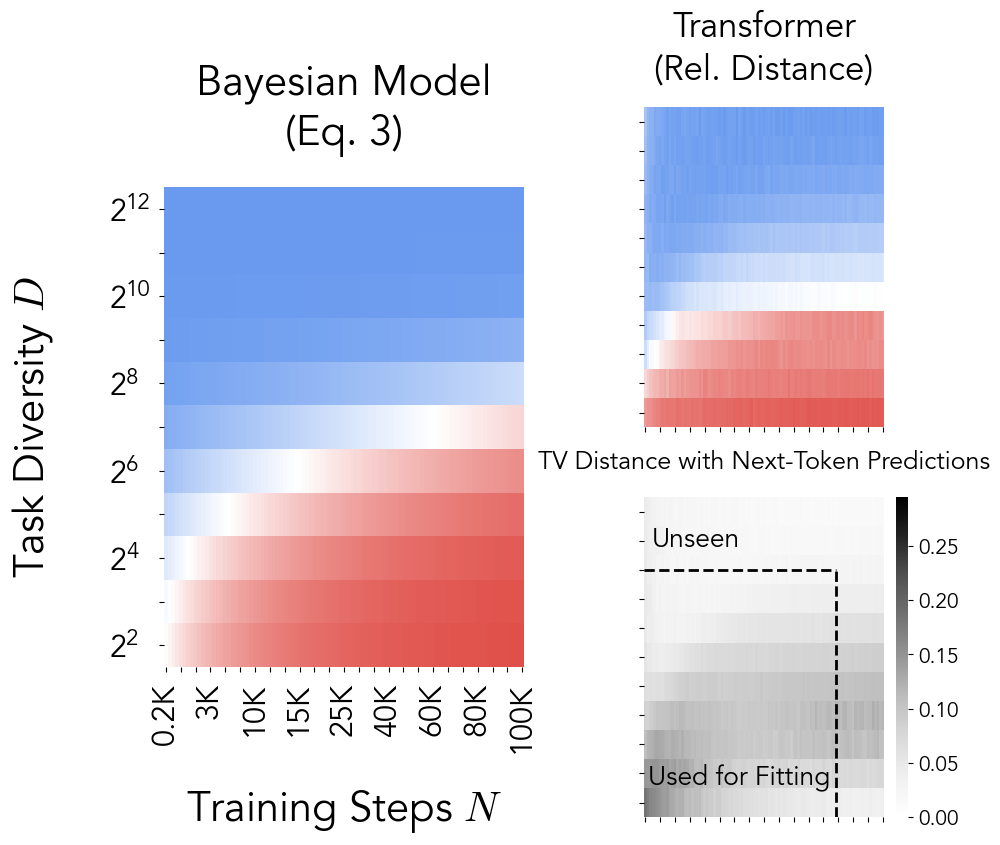

/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:2706: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbars
/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:2706: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbars
/sailhome/wurgaft/normative-icl/src/code/analysis_utils.py:2706: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbars
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:meta dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools

Saved figure to /sailhome/wurgaft/normative-icl/figures/categorical-sequence/bms_results_context_dependent_id/bms_results_context_dependent_id-categorical-sequence-320context_length__8num_dims__4mlp_expansion_factor.pdf


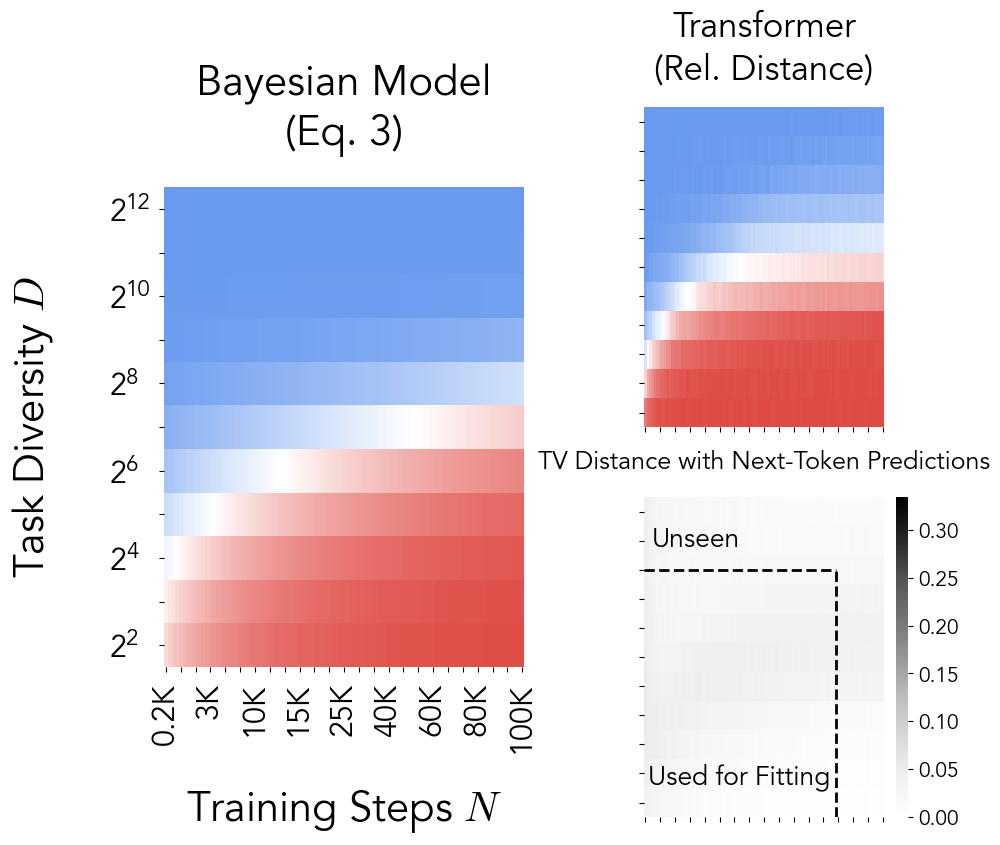

In [24]:
SAVE_FIGS = True
fixed_values = {
    "context_length": CONTEXT_LENGTH_TO_EVAL[2],
    "num_dims": NUM_DIMS_TO_EVAL[-1],
    "mlp_expansion_factor": MLP_EXPANSION_FACTOR_TO_EVAL[-1],
}

fig_gen.generate_prediction_comparison_plot(
    config={
        "fixed_values": fixed_values,
        "comparison_col": "relative_distance_eval",
        "fit_results_col": "bms_results_context_dependent",
        "custom_name": "bms_results_context_dependent_ood",
    },
    show=True,
    save=SAVE_FIGS,
)

fig_gen.generate_prediction_comparison_plot(
    config={
        "fixed_values": fixed_values,
        "comparison_col": "relative_distance_train",
        "fit_results_col": "bms_results_context_dependent",
        "custom_name": "bms_results_context_dependent_id",
    },
    show=True,
    save=SAVE_FIGS,
)

### Titration over exp params 

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:meta dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'K', 'L', 'S', 'T', 'a', 'e', 'eight', 'equal', 'five', 'g', 'h', 'i', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 10, 28, 29, 45, 47, 62, 105, 110, 114, 120, 125, 133, 136, 152, 156, 163, 171, 176, 192, 195, 200, 204, 206, 211, 221, 228]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'K', 'L', 

Saved figure to /sailhome/wurgaft/normative-icl/figures/categorical-sequence/titration_relative-distance-train_bms-weights-id_train/titration_relative-distance-train_bms-weights-id_train-categorical-sequence-128context_length__8num_dims__4mlp_expansion_factor.pdf


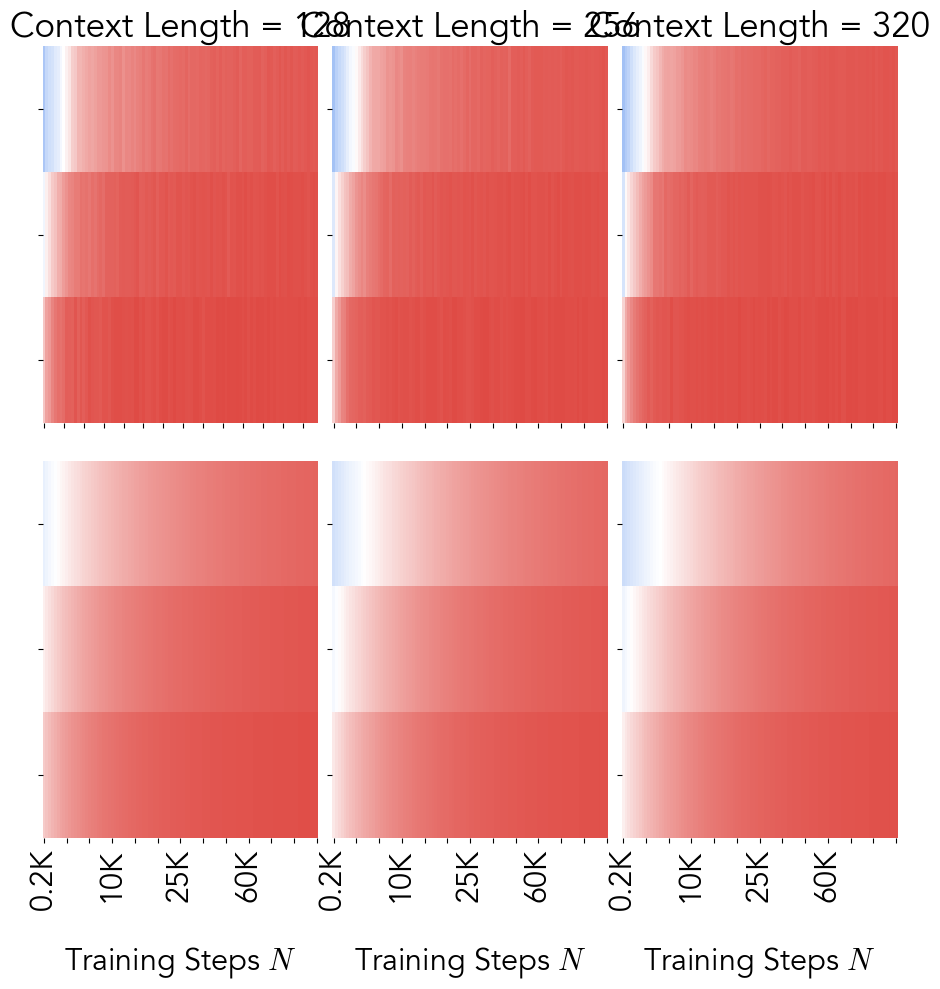

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:meta dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'K', 'L', 'S', 'T', 'a', 'e', 'eight', 'equal', 'five', 'g', 'h', 'i', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 10, 28, 29, 45, 47, 62, 105, 110, 114, 120, 125, 133, 136, 152, 156, 163, 171, 176, 192, 195, 200, 204, 206, 211, 221, 228]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'K', 'L', 

Saved figure to /sailhome/wurgaft/normative-icl/figures/categorical-sequence/titration_relative-distance-eval_bms-weights-ood_train/titration_relative-distance-eval_bms-weights-ood_train-categorical-sequence-128context_length__8num_dims__4mlp_expansion_factor.pdf


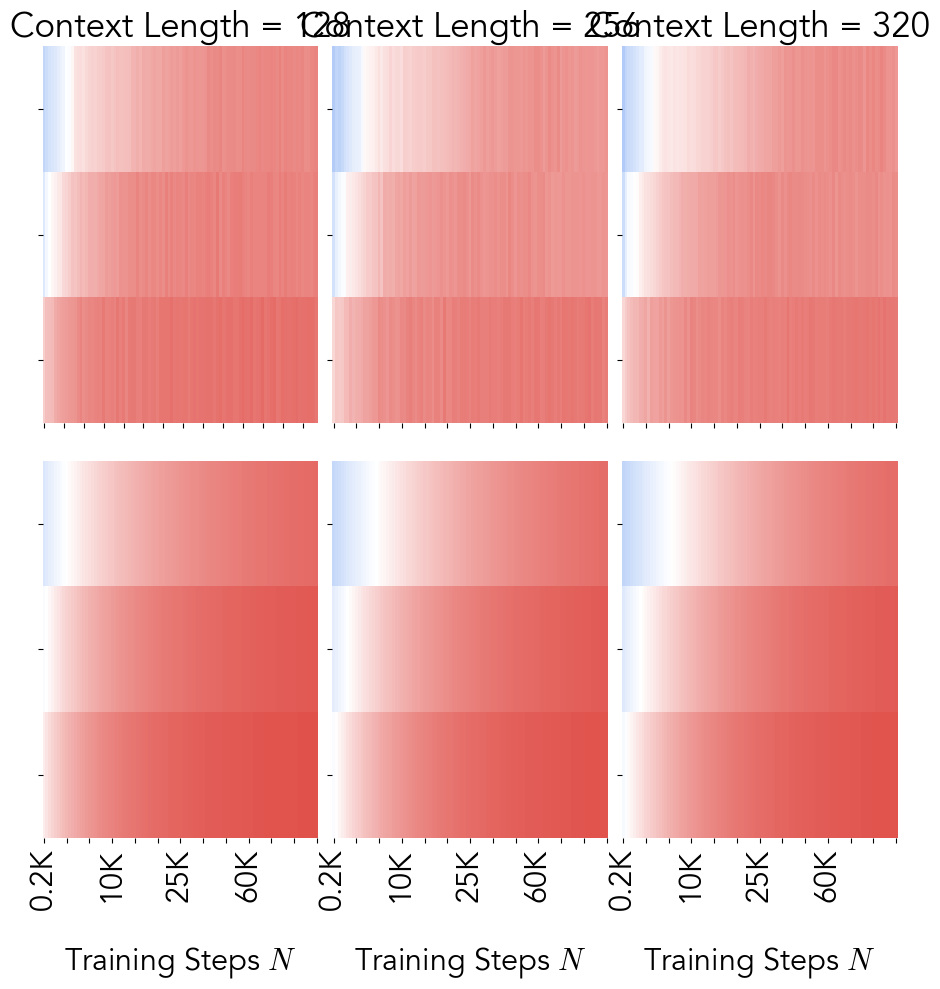

In [ ]:
transformer_df["bms_weights_id"] = transformer_df[
    "bms_results_context_dependent"
].apply(lambda x: x["weights"][0])

transformer_df["bms_weights_ood"] = transformer_df[
    "bms_results_context_dependent"
].apply(lambda x: x["ood_weights"][0])


fig_gen.generate_titration_plot(
    config={
        "col_names": ["relative_distance_train", "bms_weights_id"],
        "fixed_values": fixed_values,
        "variable_config": {
            "fixed": ["mlp_expansion_factor", "num_dims"],
            "iterate_over": ["checkpoint", "num_tasks"],
            "grid_by": "context_length",
            "custom_name": "titration_plot_context_dependent",
        },
        "hidden_size": analysis_pipeline.exp_params["hidden_size"],
        "task_diversity_values": [16, 32, 64],
    },
    show=True,
    save=SAVE_FIGS,
)

fig_gen.generate_titration_plot(
    config={
        "col_names": ["relative_distance_eval", "bms_weights_ood"],
        "fixed_values": fixed_values,
        "variable_config": {
            "fixed": ["mlp_expansion_factor", "num_dims"],
            "iterate_over": ["checkpoint", "num_tasks"],
            "grid_by": "context_length",
            "custom_name": "titration_plot_context_dependent",
        },
        "hidden_size": analysis_pipeline.exp_params["hidden_size"],
        "task_diversity_values": [16, 32, 64],
    },
    show=True,
    save=SAVE_FIGS,
)